In [2]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable
import time
import torch

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection

from monai.data import (Dataset, ArrayDataset, create_test_image_3d, DataLoader, DataLoader, 
CacheDataset, PersistentDataset, SmartCacheDataset)

from monai.transforms import (Transform, MapTransform, Randomizable, EnsureChannelFirst, EnsureChannelFirstd,
Compose, LoadImage, LoadImaged, Lambda, Lambdad, RandSpatialCrop, RandSpatialCropd, RandGaussianNoise,
RandGaussianNoised, Orientation, Rotate, MapTransform)

from monai.apps import DecathlonDataset, TciaDataset
from monai.apps.tcia import TCIA_LABEL_DICT



In [6]:
fn_keys = ("img", "seg")

root_dir =tempfile.mkdtemp()
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(128,128,128, num_objs=16, rad_max=25)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

In [9]:
#test transforms 
trans = Compose([LoadImage(image_only=True), EnsureChannelFirst()])
img = trans(filenames[0]["img"])
print(type(img), img.shape, img.get_device())

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 128, 128, 128]) -1


In [11]:
#dictionary transform
trans = Compose([LoadImaged(keys=fn_keys)])
data = trans(filenames[0])
print(list(data.keys()))
print(data['img_meta_dict'])

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']
{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3, 128, 128, 128,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(16, dtype=int16), 'bitpix': array(32, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(0, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(0., dtype=float32), 'toffset': array(0., dtype=float32), 'glmax': array(0, d

/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


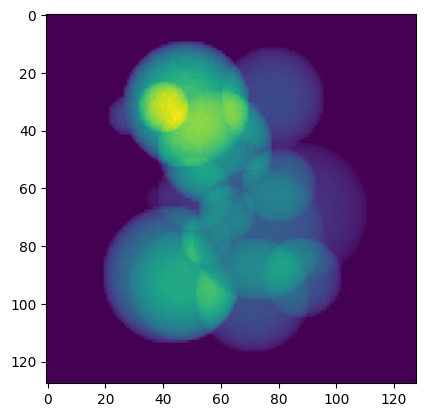

In [14]:
#wiriting a custom transform
def sum_width(img):
    return img.sum(1)

trans = Compose([LoadImage(image_only=True), Lambda(sum_width)])
data = trans(filenames[0]["img"])
plt.imshow(data)

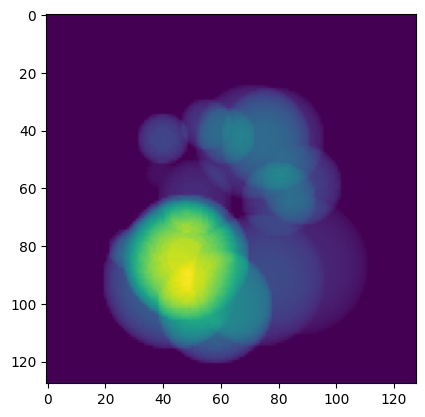

In [15]:
#subcalss from transform
class SumDimensions(Transform):
    def __init__(self, dim=1):
        self.dim = dim
    def __call__(self, inputs):
        return inputs.sum(1)
trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), SumDimensions(2)])
data = trans(filenames[0]["img"])
plt.imshow(data[0])

torch.Size([128, 128])


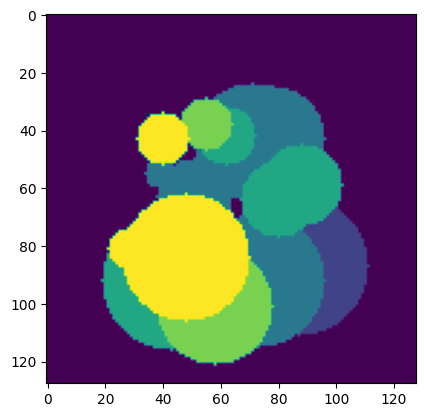

In [26]:
#using lambdad
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

trans = Compose([LoadImaged(fn_keys), EnsureChannelFirstd(fn_keys), Lambdad("img", sum_width),Lambdad("seg",max_width)])
data = trans(filenames[0])
plt.imshow(data["seg"][0][0])

In [28]:
#basic dataset
images = [fn["img"] for fn in filenames]

trans = Compose(LoadImage(image_only=True), EnsureChannelFirst())
ds = Dataset(images, trans)
image_tensor = ds[0]
print(image_tensor.shape, image_tensor.get_device())

torch.Size([128, 128, 128]) -1


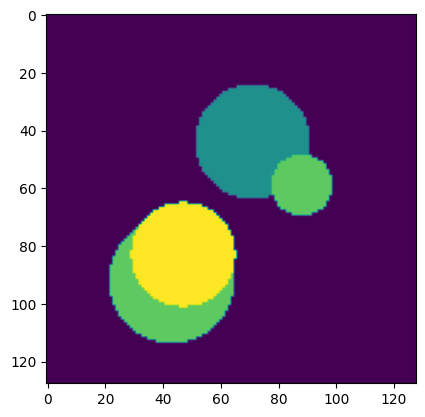

In [35]:
#array dataset - provides same random for both the images and labels
images = [fn["img"] for fn in filenames]
labels = [fn["seg"] for fn in filenames]

im_trans = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    RandSpatialCrop((128,128,128), random_size=True),
    RandGaussianNoise(0.5,1,1,)
])

seg_trans = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    RandSpatialCrop((128,128,128),random_size=True)
])

ds = ArrayDataset(images, im_trans, labels, seg_trans)
im, seg = ds[0]
plt.imshow(im[0][100])

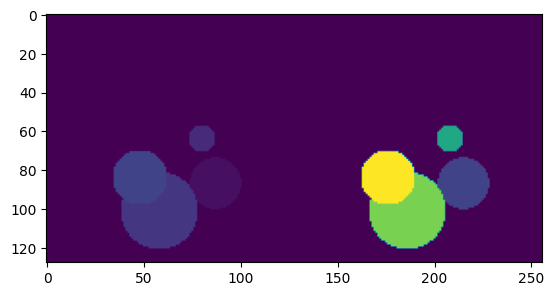

In [41]:
#using dictionary based method
trans = Compose([
    LoadImaged(fn_keys),
    EnsureChannelFirstd(fn_keys),
    RandGaussianNoised("seg"),
    RandSpatialCropd(fn_keys,(128,128,128), random_size=False),
])

ds = Dataset(filenames, trans)

item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0,48], seg.numpy()[0,48]]))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


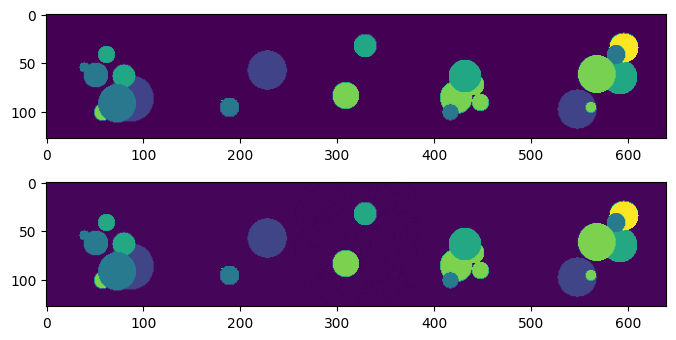

In [45]:
#using Dataloader

loader = DataLoader(ds, batch_size = 5, num_workers=5)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].imshow(np.hstack(batch["img"][:,0,64]))
ax[1].imshow(np.hstack(batch["seg"][:,0,64]))

In [47]:
data_cached = CacheDataset(filenames, transform=trans)

/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/data/dataset.py:874: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


In [53]:
per_cached = PersistentDataset(filenames, transform=trans, cache_dir="my_cache")

In [56]:
for item in per_cached:
    print(item["img"].shape)

torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])


### using the deep learning functions

In [63]:
from monai.networks.layers import Conv, Act, Pool, split_args

In [64]:
print(Conv[Conv.CONV,1])
print(Conv[Conv.CONV,2])
print(Conv[Conv.CONV, 3])

<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv3d'>


In [68]:
class MyNetwork(torch.nn.Module):
    def __init__(self, dims=3, in_channel=1, out_channel=8, kernel_size =3, pool_kernel=2, act="relu"):
        super(MyNetwork, self).__init__()
        #convoluation
        self.conv = Conv[Conv.CONV, dims](in_channel, out_channel, kernel_size)
        #activation
        act_type, act_args = split_args(act)
        self.act = Act[act_type](**act_args)
        #pooling
        self.pool = Pool[Pool.MAX, dims](pool_kernel)
    
    def forward(self, x:torch.Tensor):
        x = self.conv(x)
        x = self.act(x)
        x = self.pool(x)
        return x


In [69]:
default_net = MyNetwork()
print(default_net)
print(default_net(torch.ones(3,1,20,20,30)).shape)

MyNetwork(
  (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (act): ReLU()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 9, 9, 14])


In [91]:
net = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[8,16,32],
    strides=[2,2]
)

In [94]:
print(net(torch.ones(2,1,36,256,256)).shape)

torch.Size([2, 1, 36, 256, 256])


In [95]:
out = net(torch.ones(2,1,36,256,256))

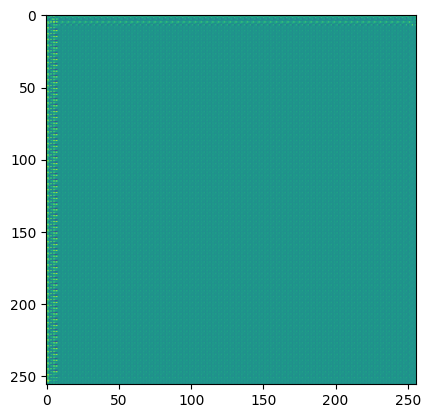

In [108]:
plt.imshow(out.detach().numpy()[0][0][20])